Import all necessary packages and functions

In [79]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from scipy.sparse import vstack, hstack
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, RocCurveDisplay

We will be looking into 3 different models:

1. Naive Bayes classification on N-grams + Bag of Words (BoW)
2. Naive Bayes classification on N-grams + TF-IDF
3. Naive Bayes classification on BoW + TF-IDF

In [52]:
with open('training_ngrams_countvec.pkl', 'rb') as f:
    ngrams_bow = pickle.load(f)

print(ngrams_bow.info())

with open('training_ngrams_tfidf.pkl', 'rb') as f:
    ngrams_tfidf = pickle.load(f)

print(ngrams_tfidf.info())


with open('engineered_features_bow_tfidf.pkl', 'rb') as f:
    bow_tfidf_dict = pickle.load(f)

bow_tfidf = pd.DataFrame(bow_tfidf_dict)

print(bow_tfidf.info())

/var/folders/g5/qt49x61j0n737l58q9zvpq640000gn/T/ipykernel_4353/3546442497.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  ngrams_bow = pickle.load(f)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100784 entries, 0 to 100783
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   body                100784 non-null  object
 1   cleaned_body        100784 non-null  object
 2   label               100784 non-null  int64 
 3   tokens              100784 non-null  object
 4   body_countvec       100784 non-null  object
 5   body_char_countvec  100784 non-null  object
dtypes: int64(1), object(5)
memory usage: 4.6+ MB
None


/var/folders/g5/qt49x61j0n737l58q9zvpq640000gn/T/ipykernel_4353/3546442497.py:7: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  ngrams_tfidf = pickle.load(f)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100784 entries, 0 to 100783
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   body             100784 non-null  object
 1   cleaned_body     100784 non-null  object
 2   label            100784 non-null  int64 
 3   tokens           100784 non-null  object
 4   body_tfidf       100784 non-null  object
 5   body_char_tfidf  100784 non-null  object
dtypes: int64(1), object(5)
memory usage: 4.6+ MB
None


/Users/sabav/vscode/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator CountVectorizer from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/sabav/vscode/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.5.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/sabav/vscode/.venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.5.1 when using ve

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125947 entries, 0 to 125946
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   X_bow             125947 non-null  object
 1   X_tfidf           125947 non-null  object
 2   label             125947 non-null  int64 
 3   bow_vectorizer    125947 non-null  object
 4   tfidf_vectorizer  125947 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.8+ MB
None


In [56]:
X_ngb_count = vstack(ngrams_bow['body_countvec'].values)
X_ngb_char = vstack(ngrams_bow['body_char_countvec'].values)
y_ngb = ngrams_bow['label'].values
X_ngb = hstack([X_ngb_count, X_ngb_char])

print(f"N-grams + BoW Feature matrix shape: {X_ngb.shape}")
print(f"N-grams + BoW Labels shape: {y_ngb.shape}")

X_ngt_count = vstack(ngrams_tfidf['body_tfidf'].values)
X_ngt_char = vstack(ngrams_tfidf['body_char_tfidf'].values)
y_ngt = ngrams_tfidf['label'].values
X_ngt = hstack([X_ngt_count, X_ngt_char])

print(f"N-grams + TF-IDF Feature matrix shape: {X_ngt.shape}")
print(f"N-grams + TF-IDF Labels shape: {y_ngt.shape}")

N-grams + BoW Feature matrix shape: (100784, 1500)
N-grams + BoW Labels shape: (100784,)
N-grams + TF-IDF Feature matrix shape: (100784, 1500)
N-grams + TF-IDF Labels shape: (100784,)


Since the Bow + TF-IDF dataset has more entries we will do random sampling.

In [55]:
sampled = bow_tfidf.sample(n=100784, random_state=42)

#Convert the sampled data into sparse matrices
X_bow_sampled = vstack(sampled['X_bow'].values)
X_tfidf_sampled = vstack(sampled['X_tfidf'].values)

X_btf = hstack([X_bow_sampled, X_tfidf_sampled])

# Labels
y_btf = sampled['label'].values

# Check the shape to confirm
print(f"BoW + TF-IDF Feature matrix shape: {X_btf.shape}")
print(f"BoW + TF-IDF Labels shape: {y_btf.shape}")

BoW + TF-IDF Feature matrix shape: (100784, 20000)
BoW + TF-IDF Labels shape: (100784,)


#1 Model Training: N-grams + BoW

In [57]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_ngb, y_ngb, test_size=0.2, random_state=42)
nb_model_1 = MultinomialNB()
nb_model_1.fit(X_train_1, y_train_1)
y_pred_1 = nb_model_1.predict(X_test_1)
y_probs_1 = nb_model_1.predict_proba(X_test_1)[:, 1]

#2 Model Training: N-grams + TF-IDF

In [58]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_ngt, y_ngt, test_size=0.2, random_state=42)
nb_model_2 = MultinomialNB()
nb_model_2.fit(X_train_2, y_train_2)
y_pred_2 = nb_model_2.predict(X_test_2)
y_probs_2 = nb_model_2.predict_proba(X_test_2)[:, 1]

#3 Model Training: BoW + TF-IDF

In [59]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_btf, y_btf, test_size=0.2, random_state=42)
nb_model_3 = MultinomialNB()
nb_model_3.fit(X_train_3, y_train_3)
y_pred_3 = nb_model_3.predict(X_test_3)
y_probs_3 = nb_model_3.predict_proba(X_test_3)[:, 1]

Now we shall compare the performance of all 3 models using classification report and confusion matrices.

In [71]:
def performance(y_test, y_pred, y_probs, model):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_probs)

    print(model)

    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC:       {auc:.4f}")

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Ham", "Spam"], yticklabels=["Ham", "Spam"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix : {model}", loc='center')
    plt.show()
    
    return accuracy, precision, recall, f1, auc

N-grams + BoW Performance
Accuracy:  0.8653
Precision: 0.9098
Recall:    0.7958
F1 Score:  0.8490
AUC:       0.9408


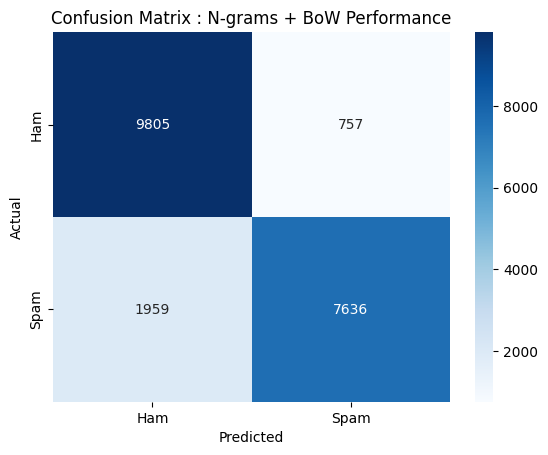

N-grams + TF-IDF Performance
Accuracy:  0.9205
Precision: 0.9179
Recall:    0.9147
F1 Score:  0.9163
AUC:       0.9772


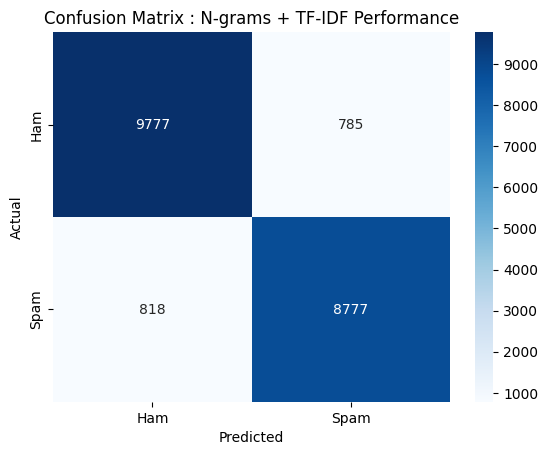

BoW + TF-IDF Performance
Accuracy:  0.9430
Precision: 0.9635
Recall:    0.9150
F1 Score:  0.9386
AUC:       0.9840


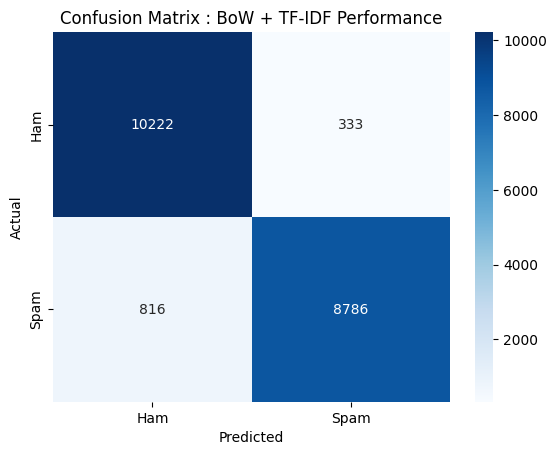

Results with Best Performing Model per Metric:
              Model      Accuracy     Precision        Recall      F1 Score  \
0     N-grams + BoW      0.865258      0.909806      0.795831       0.84901   
1  N-grams + TF-IDF      0.920474      0.917904      0.914747      0.916323   
2      BoW + TF-IDF      0.942997      0.963483      0.915018      0.938625   
3        Best Model  BoW + TF-IDF  BoW + TF-IDF  BoW + TF-IDF  BoW + TF-IDF   

            AUC  
0      0.940772  
1       0.97716  
2      0.983984  
3  BoW + TF-IDF  


In [77]:
results = []

acc1, prec1, rec1, f1_1, auc1 = performance(y_test_1, y_pred_1, y_probs_1, "N-grams + BoW Performance")
acc2, prec2, rec2, f1_2, auc2 = performance(y_test_2, y_pred_2, y_probs_2, "N-grams + TF-IDF Performance")
acc3, prec3, rec3, f1_3, auc3 = performance(y_test_3, y_pred_3, y_probs_3, "BoW + TF-IDF Performance")

results.append(['N-grams + BoW', acc1, prec1, rec1, f1_1, auc1])
results.append(['N-grams + TF-IDF', acc2, prec2, rec2, f1_2, auc2])
results.append(['BoW + TF-IDF', acc3, prec3, rec3, f1_3, auc3])

results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])
best_model_acc = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
best_model_prec = results_df.loc[results_df['Precision'].idxmax(), 'Model']
best_model_rec = results_df.loc[results_df['Recall'].idxmax(), 'Model']
best_model_f1 = results_df.loc[results_df['F1 Score'].idxmax(), 'Model']
best_model_auc = results_df.loc[results_df['AUC'].idxmax(), 'Model']
# Add a row for the best performing model
best_model_row = pd.DataFrame([['Best Model', best_model_acc, best_model_prec, best_model_rec, best_model_f1, best_model_auc]], columns=results_df.columns)

# Append the row to the results DataFrame
results_df = pd.concat([results_df, best_model_row], ignore_index=True)

# Display the updated results with the best model name
print("Results with Best Performing Model per Metric:")
print(results_df)

It seems BoW + TF-IDF outperforms both N-grams models. The following ROC curves help to visualise the FPR which will be important especially for classification modelling.

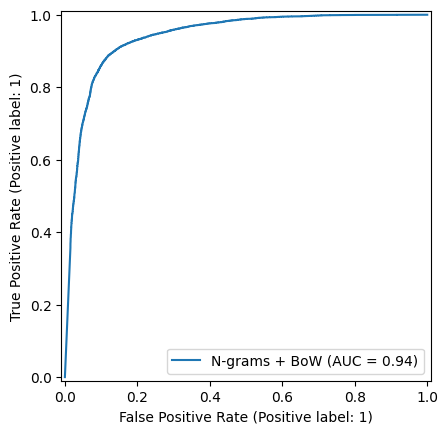

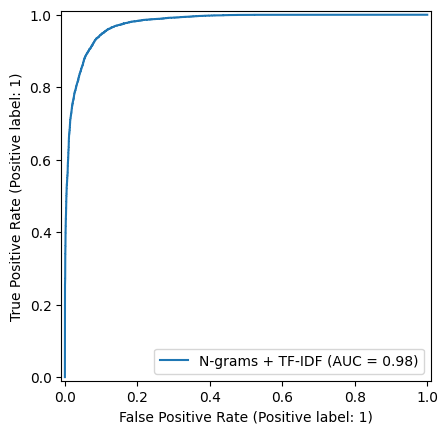

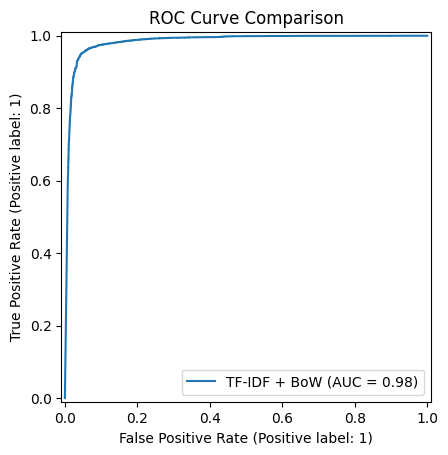

In [82]:
RocCurveDisplay.from_estimator(nb_model_1, X_test_1, y_test_1, name="N-grams + BoW")
RocCurveDisplay.from_estimator(nb_model_2, X_test_2, y_test_2, name="N-grams + TF-IDF")
RocCurveDisplay.from_estimator(nb_model_3, X_test_3, y_test_3, name="TF-IDF + BoW")

plt.title("ROC Curve Comparison")
plt.show()